In [1]:
import random
from itertools import chain, cycle, islice
import torch
from torch.utils.data import *
import time
import torch.utils.data as data
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

In [2]:
def count(start=0, step=1):
    # count(10) --> 10 11 12 13 14 ...
    # count(2.5, 0.5) -> 2.5 3.0 3.5 ...
    n = start
    while True:
        yield n
        n += step

#> see:https://gist.github.com/david-macleod/2b933d28fd3ac09766785728ee191f09
def plot_timings(loader, n_batches, model_time=0.2, max_time=2.5):
    
    fig, ax = plt.subplots()
    ax.set_axisbelow(True)
    ax.yaxis.grid(which="major", color='black', linewidth=1)
    
    zero_time = time.time()
    
    worker_ids = {}
    worker_count = count() # added by CCJ;
    
    for result in islice(loader, n_batches):
        start = time.time()
        time.sleep(model_time)
        end = time.time()
                
        # check if already batched
        if isinstance(result[0], torch.Tensor):
            result = zip(*result)
            
        batch = []
        #print ('result = ', result)
        for item in result:
            data, worker, t1, t2 = tuple(map(scalar, item))
            #print ("processing worker id = %d"% worker )
            # fix worker position in plot
            if worker != -1:
                if worker not in worker_ids:
                    worker_ids[worker] = next(worker_count)
                worker = worker_ids[worker]
   
            plot_time_box(data, worker, t1-zero_time, t2-zero_time, ax)
            batch.append(data)
        
        batch_str = "-".join([str(batch[0]), str(batch[-1])])
        plot_time_box(batch_str, -1, start-zero_time, end-zero_time, ax, color='firebrick')
    
    max_worker = len(worker_ids) - 1 
        
    ax.set_xlim(0, max_time)
    ax.set_ylim(-1.5, max_worker + 0.5)
    ax.set_xticks(np.arange(0, max_time, 0.2))
    ax.set_yticks(np.arange(-1, max_worker+1, 1))
    ax.set_yticklabels([])
    ax.tick_params(axis='y', colors=(0,0,0,0))
    
    fig.set_figwidth(16)
    fig.set_figheight((max_worker + 2) * 0.5)
    
    ax.xaxis.label.set_color('gray')
    ax.tick_params(axis='x', colors='gray')
    for spine in ax.spines.values():
        spine.set_edgecolor((0,0,0,0))
    # for showing image 
    #plt.show()
    

        
def scalar(x):
    return x.item() if hasattr(x, 'item') else x

def plot_time_box(data, worker, t1, t2, ax, color='steelblue'):
    x = t1
    y = worker - 0.25
    w = t2 - t1
    h = 0.6
    
    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='black',facecolor=color)
    
    ax.add_patch(rect)
    
    ax.text(x + (w * 0.5), y + (h * 0.5), str(data), va='center', ha='center', color='white', weight='bold') 

In [45]:
data = list(range(256))

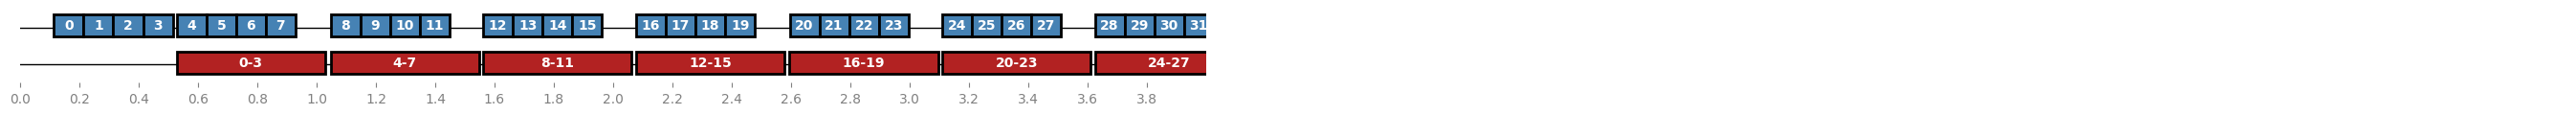

In [57]:
class MyMapDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        worker = torch.utils.data.get_worker_info()
        worker_id = worker.id if worker is not None else -1
        
        start = time.time()
        time.sleep(0.1)
        end = time.time()
        return self.data[idx], worker_id, start, end
    
map_dataset = MyMapDataset(data)

loader = DataLoader(map_dataset, batch_size = 4, num_workers = 1, prefetch_factor = 1)
plot_timings(loader, n_batches = 16, model_time=0.5, max_time = 4.0)

In [3]:
from pprint import pprint
def plot_timings_multi(loader, n_batches, model_time=0.2, max_time=2.5):
    
    fig, ax = plt.subplots()
    ax.set_axisbelow(True)
    ax.yaxis.grid(which="major", color='black', linewidth=1)
    
    zero_time = time.time()
    
    worker_ids = {}
    worker_count = count() # added by CCJ;
    
    for iteration, result in enumerate(islice(loader, n_batches)):
        start = time.time()
        time.sleep(model_time)
        end = time.time()
        
        data_dict, worker_id, _, _, time_dict = result
        
        bsz = len(worker_id)
        
        batch = []
        for i in range(bsz):
            
            if worker_id[i].item() != -1:
                if worker_id[i].item() not in worker_ids:
                    worker_ids[worker_id[i].item()] = next(worker_count)
                worker = worker_ids[worker_id[i].item()]
            
            for mode in data_dict:
                t1 = time_dict[mode]['start'][i].item()
                t2 = time_dict[mode]['end'][i].item()
                plot_time_box(f'{iteration}-{mode}', worker, t1-zero_time, t2-zero_time, ax)
                
            batch.append(mode)
        
            # batch_str = "-".join([str(batch[0]), str(batch[-1])])
            batch_str = str(iteration)
        plot_time_box(batch_str, -1, start-zero_time, end-zero_time, ax, color='firebrick')
    
    max_worker = loader.num_workers - 1
        
    ax.set_xlim(0, max_time)
    ax.set_ylim(-1.5, max_worker + 0.5)
    ax.set_xticks(np.arange(0, max_time, 0.2))
    ax.set_yticks(np.arange(-1, max_worker+1, 1))
    ax.set_yticklabels([])
    ax.tick_params(axis='y', colors=(0,0,0,0))
    
    fig.set_figwidth(16)
    fig.set_figheight((max_worker + 2) * 0.5)
    
    ax.xaxis.label.set_color('gray')
    ax.tick_params(axis='x', colors='gray')
    for spine in ax.spines.values():
        spine.set_edgecolor((0,0,0,0))

tensor([0, 0])
tensor([1, 1])
tensor([0, 0])
tensor([1, 1])


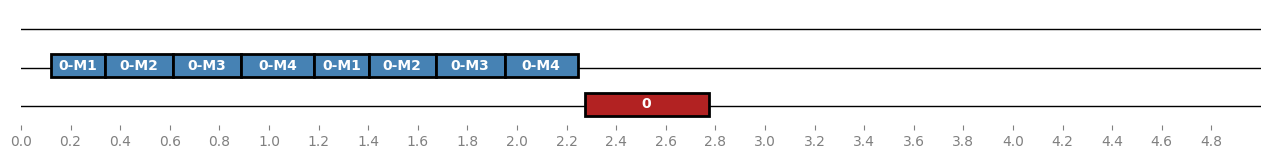

In [20]:
class MyMultimodalIterableDataset(IterableDataset):
    def __init__(self, modes, data_dict, buffer_size = 100, process_times = None, max_count = 10):
        self.data_dict = data_dict
        self.modes = modes
        self.buffer_size = buffer_size
        if process_times is None:
            self.process_times = { mode : 0.1 for mode in modes }
        else:
            self.process_times = process_times
        
        self.max_count = max_count
        self.count = 0
        self.clock = 0
        
    def process(self, data, mode):
        start = time.time()
        time.sleep(self.process_times[mode])
        end = time.time()
        return data, start, end
    
    def __iter__(self):
        while self.count < self.max_count:
            current = 2
            data_dict = {}
            time_dict = { mode : {} for mode in self.modes }
            
            worker = torch.utils.data.get_worker_info()
            worker_id = worker.id if worker is not None else -1
            
            start = time.time()
            for mode in self.modes:
                data = self.data_dict[mode][current]
                data_dict[mode], time_dict[mode]['start'], time_dict[mode]['end'] = self.process(data, mode)
                
            end = time.time()
            yield data_dict, worker_id, start, end, time_dict

# def worker_init_fn(_):
#     worker_info = torch.utils.data.get_worker_info()
    
            
def collate_fn(batch):
    batch = torch.utils.data.dataloader.default_collate(batch)
    print(batch[1])
    return batch

modes = [f'M{i + 1}' for i in range(4)]
buffer_size = 100
data_dict = { mode : [1 for _ in range(buffer_size)] for mode in modes }
process_times = { mode : random.random() * 0.2 + 0.15 for mode in modes }
multimodal_dataset = MyMultimodalIterableDataset(modes = modes,
                                                 data_dict = data_dict,
                                                 buffer_size = buffer_size,
                                                 process_times = process_times,
                                                 max_count = 8)

loader = DataLoader(multimodal_dataset,
                    batch_size = 2,
                    num_workers = 2,
                   collate_fn = collate_fn)

query_interval = 0.5
plot_timings_multi(loader, 1, model_time = 0.5, max_time = 5.0)

4
{'M0': 1}
4
{'M1': 1}
4
{'M0': 1}


ValueError: too many values to unpack (expected 5)

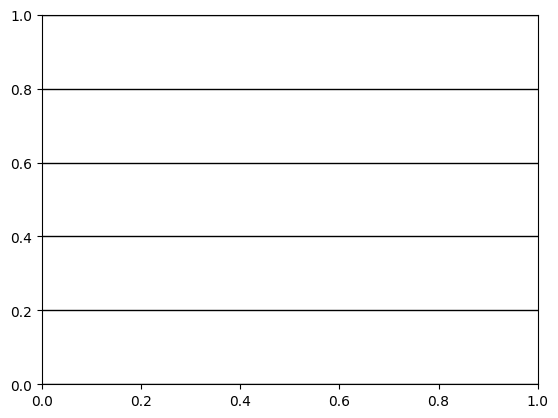

In [216]:
class MyMultimodalIterableDataset(IterableDataset):
    def __init__(self, modes, data_dict, buffer_size = 100, process_times = None, max_count = 10):
        self.data_dict = data_dict
        self.modes = modes
        self.buffer_size = buffer_size
        if process_times is None:
            self.process_times = { mode : 0.1 for mode in modes }
        else:
            self.process_times = process_times
        
        self.max_count = max_count
        self.count = 0
        self.clock = 0
        
    def process(self, data, mode):
        start = time.time()
        time.sleep(self.process_times[mode])
        end = time.time()
        return data, start, end
    
    def __iter__(self):
        while self.count < self.max_count:
            self.count += 1
            current = 0
            data_dict = {}
            time_dict = { mode : {} for mode in self.modes }
            
            worker = torch.utils.data.get_worker_info()
            worker_id = worker.id if worker is not None else -1
            
            start = time.time()
            for mode in self.modes:
                data = self.data_dict[mode][current]
                data_dict[mode], time_dict[mode]['start'], time_dict[mode]['end'] = self.process(data, mode)
                
            end = time.time()
            yield data_dict, worker_id, start, end, time_dict, self.count

def worker_init_fn(_):
    worker_info = torch.utils.data.get_worker_info()
    dataset = worker_info.dataset
    worker_id = worker_info.id
    
    assert len(dataset.modes) == worker_info.num_workers
    
    dataset.modes = [dataset.modes[worker_id]]
            
def collate_fn(batch):
    new_data_dict = {}
    new_batch = []
    print(len(batch))
    for item in batch:
        data_dict, worker_id, start, end, time_dict, counts = item
        for mode in data_dict:
            new_data_dict[mode] = data_dict[mode]
    print(new_data_dict)
    batch = torch.utils.data.dataloader.default_collate(batch)
    return batch

modes = [f'M{i}' for i in range(2)]
buffer_size = 100
data_dict = { mode : [1 for _ in range(buffer_size)] for mode in modes }
process_times = { mode : random.random() * 0.2 + 0.15 for mode in modes }
multimodal_dataset = MyMultimodalIterableDataset(modes = modes,
                                                 data_dict = data_dict,
                                                 buffer_size = buffer_size,
                                                 process_times = process_times,
                                                 max_count = 16)

loader = DataLoader(multimodal_dataset,
                    batch_size = 4,
                    num_workers = 2,
                   worker_init_fn = worker_init_fn,
                   collate_fn = collate_fn,)

query_interval = 0.5
plot_timings_multi(loader, 1, model_time = 0.2, max_time = 5.0)

In [41]:
def plot_timings(loader, n_batches, model_time=0.2, max_time=2.5):
    
    fig, ax = plt.subplots()
    ax.set_axisbelow(True)
    ax.yaxis.grid(which="major", color='black', linewidth=1)
    
    zero_time = time.time()
    
    worker_ids = {}
    worker_count = count()
        
    for result in islice(loader, n_batches):
        start = time.time()
        time.sleep(model_time)
        end = time.time()
                
        # check if already batched
        if isinstance(result[0], torch.Tensor):
            result = zip(*result)
            
        batch = []
        for item in result:
            data, worker, t1, t2 = tuple(map(scalar, item))
            
            # fix worker position in plot
            if worker != -1:
                if worker not in worker_ids:
                    worker_ids[worker] = next(worker_count)
                worker = worker_ids[worker]
   
            plot_time_box(data, worker, t1-zero_time, t2-zero_time, ax)
            batch.append(data)
        
        batch_str = ",".join(map(str, batch))
        plot_time_box(batch_str, -1, start-zero_time, end-zero_time, ax, color='firebrick')
    
    max_worker = len(worker_ids) - 1 
        
    ax.set_xlim(0, max_time)
    ax.set_ylim(-1.5, max_worker + 0.5)
    ax.set_xticks(np.arange(0, max_time, 0.2))
    ax.set_yticks(np.arange(-1, max_worker+1, 1))
    ax.set_yticklabels([])
    ax.tick_params(axis='y', colors=(0,0,0,0))
    
    fig.set_figwidth(16)
    fig.set_figheight((max_worker + 2) * 0.5)
    
    ax.xaxis.label.set_color('gray')
    ax.tick_params(axis='x', colors='gray')
    for spine in ax.spines.values():
        spine.set_edgecolor((0,0,0,0))
        
def scalar(x):
    return x.item() if hasattr(x, 'item') else x

def plot_time_box(data, worker, t1, t2, ax, color='steelblue'):
    x = t1
    y = worker - 0.25
    w = t2 - t1
    h = 0.6
    
    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='black',facecolor=color)
    
    ax.add_patch(rect)
    
    ax.text(x + (w * 0.5), y + (h * 0.5), str(data), va='center', ha='center', color='white', weight='bold')  


In [179]:
class MyMultimodalIterableDataset(IterableDataset):
    def __init__(self, data_list, batch_size):
        self.data_list = data_list
        self.batch_size = batch_size
        
    @property
    def shuffled_data_list(self):
        # return self.data_list
        return random.sample(self.data_list, len(self.data_list))
    
    def process_data(self, data):
        for x in data:
            worker = torch.utils.data.get_worker_info()
            worker_id = id(self) if worker is not None else -1
            
            start = time.time()
            time.sleep(0.1)
            end = time.time()
            yield x[1], worker_id, start, end
            
    def get_stream(self, data_list):
        return chain.from_iterable(map(self.process_data, cycle(data_list)))
    
    def get_streams(self):
        return zip(*[self.get_stream(self.shuffled_data_list) for _ in range(self.batch_size)])
    
    def __iter__(self):
        return self.get_streams()
    
    @classmethod
    def split_datasets(cls, data_dict, max_workers):
        n_modes = len(data_dict)
        for n in range(max_workers, 0, -1):
            if n_modes % n == 0:
                num_workers = n
                break
        
        
        split_size = n_modes // num_workers
        
        datasets = [ [] for _ in range(num_workers)]
        for i, mode in enumerate(data_dict):
            datasets[i % num_workers] += [data_dict[mode]]
        return [cls(datasets[j], batch_size = split_size) for j in range(num_workers)]
    
class MultiStreamDataLaoder:
    def __init__(self, datasets):
        self.datasets = datasets
        
    def get_stream_loaders(self):
        return zip(*[DataLoader(dataset, num_workers = 1, batch_size = None) for dataset in datasets])
    
    def __iter__(self):
        for batch_parts in self.get_stream_loaders():
            yield list(chain(*batch_parts))

modes = [f'M{i + 1}' for i in range(8)]
data_dict = { mode : [(j, f'{mode}-{j}') for j in range(4)] for mode in modes }

In [189]:
datasets = MyMultimodalIterableDataset.split_datasets(data_dict, max_workers = 2)

loader = MultiStreamDataLaoder(datasets)

loaders = loader.get_stream_loaders()

loader_ = next(loaders)
print(len(loader_[1]))
           
          

# plot_timings(loader, model_time = 0.2, n_batches = 4)

4


In [ ]:
class UnimodalIterableDataset(IterableDataset):
    def __init__(self, mode, data_ptr, load_time = 0.05, process_time = 0.1):
        self.mode = mode
        self.data_ptr = data_ptr
        self.load_time = load_time
        self.process_time = process_time
        self.dummy = torch.randn(10)

    def load_data(self):
        start_t = time.time()
        time.sleep(self.load_time)
        end_t = time.time()
        
        return self.dummy, start_t, end_t
    
    def process_data(self, data):
        start_t = time.time()
        time.sleep(self.process_time)
        end_t = time.time()
        
        return data, start_t, end_t
        
    def __iter__(self):
        while True:
            time_dict = { 'load' : {}, 'process' : {} }
            
            data, time_dict['load']['start'] = self.load_data()
            data, time_dict['process']['end'] = self.process_data(data)
            
            worker = torch.utils.data.get_worker_info()
            worker_id = worker.id if worker is not None else -1
            
            yield data, worker_id, time_dict

class MultimodalDataLoader:
    def __init__(self, datasets):
        self.datasets = datasets
        self.modes = list(datasets.keys())
        
    def __iter__(self):
        
        
n_modes = 4
modes = [f'M{i + 1}' for i in range(n_modes)] 
datasets = { mode : UnimodalIterableDataset(mode, None) for mode in modes }

        